In [1]:
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import scipy.stats as si
import os


In [2]:
data = yf.download("ETH-USD", start="2021-03-31", end="2022-03-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data['Adj Close'].head()

Date
2021-03-30    1846.033691
2021-03-31    1918.362061
2021-04-01    1977.276855
2021-04-02    2143.225586
2021-04-03    2028.422485
Name: Adj Close, dtype: float64

In [4]:
data['Adj Close'].tail()

Date
2022-03-26    3143.178955
2022-03-27    3291.577637
2022-03-28    3336.634521
2022-03-29    3401.987793
2022-03-30    3385.157959
Name: Adj Close, dtype: float64

In [5]:
S = data['Adj Close'][-1]
print('The spot price is $', round(S,2), '.')

The spot price is $ 3385.16 .


In [6]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
vol_h = np.sqrt(365) * log_return.std()
print('The annualised volatility is', round(vol_h*100,2), '%')

The annualised volatility is 98.26 %


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000270C4482048>],
      dtype=object)

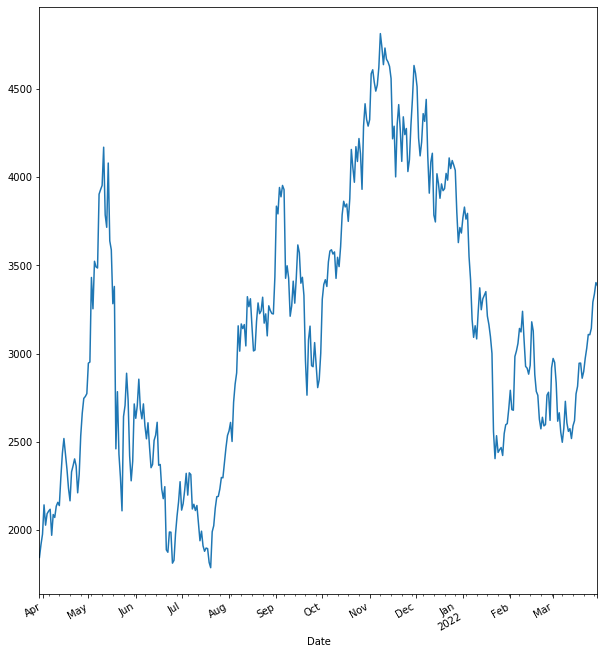

In [7]:
data['Adj Close'].plot(figsize=(10, 12), subplots=True)

# Binomial Model

In [8]:
import numpy as np
import os

In [9]:
S0 = 3385.16              # spot stock price
K = 3300.0               # strike
T = 2/12                 # maturity 
r = 0.024                 # risk free rate 
sig = 0.2               # diffusion coefficient or volatility
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff 

In [10]:
dT = float(T) / N                             # Delta t
u = np.exp(sig * np.sqrt(dT))                 # up factor
d = 1.0 / u                                   # down factor 

In [11]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [12]:
S

array([[3385.16      , 3548.55906776, 3719.84528275, 3899.39935151],
       [   0.        , 3229.2849032 , 3385.16      , 3548.55906776],
       [   0.        ,    0.        , 3080.58732409, 3229.2849032 ],
       [   0.        ,    0.        ,    0.        , 2938.73676241]])

In [13]:
a = np.exp(r * dT)    # risk free compound return
p = (a - d)/ (u - d)  # risk neutral up probability
q = 1.0 - p           # risk neutral down probability
p

0.5023633968665896

In [14]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,  70.7150968 ],
       [  0.        ,   0.        ,   0.        , 361.26323759]])

In [15]:
# for European Option
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 70.62971156,  17.46540479,   0.        ,   0.        ],
       [  0.        , 124.48836531,  35.14353127,   0.        ],
       [  0.        ,   0.        , 215.01560794,  70.7150968 ],
       [  0.        ,   0.        ,   0.        , 361.26323759]])

In [16]:
print('European ' + payoff, str( V[0,0]))

European put 70.6297115603254


# Monte Carlo Simulation

In [17]:
def mcs_simulation_np(p):
    M = p
    I = p
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - sigma ** 2 / 2) * dt + sigma * np.sqrt(dt) * rn[t]) 
    return S
 

In [18]:
T = 2/12
r = 0.024
sigma = 0.982
S0 = 3385.16
K = 3300

In [19]:
S = mcs_simulation_np(10000)

In [20]:
S = np.transpose(S)
S

array([[3385.16      , 3386.23264679, 3386.50931493, ..., 3606.99804004,
        3601.60672487, 3603.45887932],
       [3385.16      , 3386.58012282, 3378.0810837 , ..., 2453.86960243,
        2447.47933064, 2448.57259987],
       [3385.16      , 3404.66667385, 3415.75498533, ..., 1446.86177574,
        1444.56240944, 1448.0811284 ],
       ...,
       [3385.16      , 3367.58139043, 3367.96957649, ..., 1740.35442713,
        1733.09174969, 1732.19710815],
       [3385.16      , 3381.53630694, 3384.15690748, ..., 3808.09181016,
        3793.52157426, 3821.40843786],
       [3385.16      , 3378.09366791, 3380.19677565, ..., 2367.53154792,
        2377.68545558, 2362.30591668]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-period values')

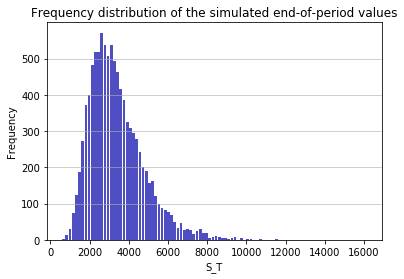

In [21]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-period values')

In [22]:
p = np.mean(np.maximum(K - S[:,-1],0))
print('European put', str(p))

European put 488.8665077990523


In [23]:
c = np.mean(np.maximum(S[:,-1] - K,0))
print('European call', str(c))

European call 580.8876275596589


# Black and Scholes Model 

In [24]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol_h ** 2) * T) / (vol_h * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [25]:
S = 3385.16
K = 3300
T = 2/12
r = 0.024

In [26]:
call = euro_option_bs(S, K, T, r, vol_h, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 580.87


In [27]:
put = euro_option_bs(S, K, T, r, vol_h, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 482.54


In [28]:
S = np.linspace(3000,4500,100)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 3000, 2/12, 0.024, .986, 'call')

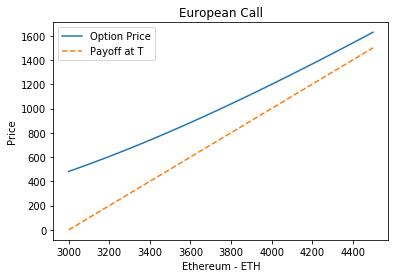

In [29]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-3000,0), '--')
plt.xlabel('Ethereum - ETH')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [30]:
S = np.linspace(3000,3500,100)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 3000, 2/12, 0.024, .986, 'put')

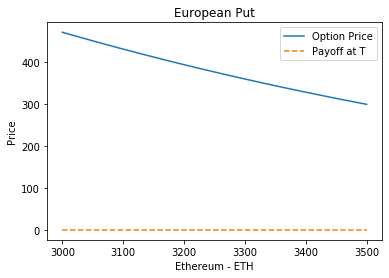

In [31]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(3000-S,0), '--')
plt.xlabel('Ethereum - ETH')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

# Greeks 

# Delta

In [32]:
def delta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        delta = np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  - np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [33]:
delta(3300, 3380, 2/12, 0.024, 0, 0.9826, 'call')

0.5599457354253725

In [34]:
delta(3300, 3380, 2/12, 0.024, 0, 0.9826, 'put')

-0.44005426457462754

In [35]:
S = np.linspace(3000,3500,100)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 3500, 2/12, 0.024, 0, 0.9826, 'call')
    Delta_Put [i] = delta(S[i], 2500, 2/12, 0.024, 0, 0.9826, 'put')

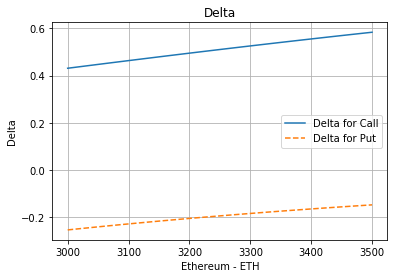

In [36]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Ethereum - ETH')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [37]:
S = np.linspace(3000, 3500, 100)
T = np.linspace(0.5, 2, 100)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 3500, T[i], 0.024, 0, 0.9826, 'call')

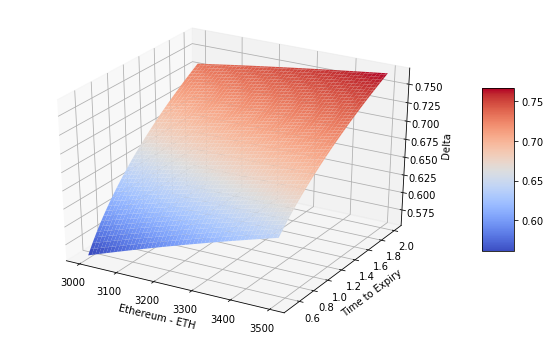

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum - ETH')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Gamma

In [39]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [40]:
gamma(3000, 3500, 2/12, 0.024, 0, 0.9826, 'call')

0.0003265378143812824

In [41]:
gamma(3000, 2500, 2/12, 0.024, 0, 0.9826, 'put')

0.00026573341436121216

In [42]:
S = np.linspace(3000,3500,100)
Gamma_Call = np.zeros((len(S),1))
Gamma_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 3500, 2/12, 0.024, 0, 0.9826, 'call')
    Gamma [i] = gamma(S[i], 2500, 2/12, 0.024, 0, 0.9826, 'call')

NameError: name 'Gamma' is not defined

In [ ]:
fig = plt.figure()
plt.plot(S, Gamma_Call, '-')
plt.plot(S, Gamma_Put, '--')
plt.grid()
plt.xlabel('Ethereum - ETH')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

# Surface of Gamma

In [ ]:
def gamma(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    gamma = np.exp(- r * T) * si.norm.pdf(d1, 0.0, 1.0) / (vol * S * np.sqrt(T))
    
    return gamma

In [ ]:
S = np.linspace(3000, 3500, 100)
T = np.linspace(0.5, 2, 100)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 3500, T[i], 0.024, 0, 0.9826, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum - ETH')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Speed

In [ ]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [ ]:
speed(3000, 3500, 2/12, 0.024, 0, 0.9826, 'call')

In [ ]:
speed(3000, 2500, 2/12, 0.024, 0, 0.9826, 'put')

In [ ]:
S = np.linspace(3000,3500,100)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 3500, 2/12, 0.024, 0, 0.9826, 'call')

In [ ]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Ethereum - ETH')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

# Surface of Speed

In [ ]:
def speed(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    speed = - np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + vol * np.sqrt(T))
    
    return speed

In [ ]:
S = np.linspace(3000, 3500, 100)
T = np.linspace(0.5, 2, 100)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 3500, T[i], 0.024, 0, 0.9826, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum - ETH')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Theta

In [ ]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(-q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [ ]:
theta(3000, 3500, 2/12, 0.024, 0, 0.9826, 'call')

In [ ]:
theta(3000, 2500, 2/12, 0.024, 0, 0.9826, 'put')

In [ ]:
T = np.linspace(.01,.31,31)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(3000, 3500, T[i], 0.024, 0, 0.98267, 'call')
    Theta_Put [i] = theta(3000, 2500, T[i], 0.024, 0, 0.9826, 'put')

In [ ]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Theta')
plt.ylabel('Price')
plt.title('Time to Expiry')
plt.legend(['Theta for Call', 'Theta for Put'])

# Surface of Theta

In [ ]:
def theta(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = vol * S * np.exp(- q * T) * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - q * S * np.exp(-q * T) * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [ ]:
S = np.linspace(3000, 3500, 100)
T = np.linspace(0.01, 0.31, 100)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 3500, T[i], 0.024, 0, 0.9826, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum - ETH')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

# Rho

In [ ]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [ ]:
rho(3000, 3500, 2/12, 0.024, 0, 0.9826, 'call')

In [ ]:
rho(3000, 2500, 2/12, 0.024, 0, 0.9826, 'put')

In [ ]:
r = np.linspace(0,0.1,50)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(3000, 3500, 2/12, r[i], 0, 0.9826, 'call')
    Rho_Put [i] = rho(3000, 2500, 2/12, r[i], 0, 0.9826, 'put')

In [ ]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Rho')
plt.ylabel('Price')
plt.title('Time to Expiry')
plt.legend(['Rho for Call', 'Rho for Put'])

# Surface of Rho

In [ ]:
def rho(S, K, T, r, q, vol, payoff):
    
    d1 = (np.log(S / K) + (r - q + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - q - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [ ]:
S = np.linspace(3000, 3500, 100)
T = np.linspace(0.5, 2, 100)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 3500, T[i], 0.024, 0, 0.9826, 'call')

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Ethereum - ETH')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);